In [1]:
from statistics import mean
from statistics import stdev
import time
import numpy as np
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV


import shap
from sklearn import tree
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('Clean_Data.csv', low_memory=False)

In [3]:
df = df.drop(['Unnamed: 0'], axis = 1)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 972006 entries, 0 to 972005
Columns: 233 entries, atlas_pct_laccess_child15 to race_cd
dtypes: float64(150), int64(14), object(69)
memory usage: 1.7+ GB


# Scaling of Columns

In [5]:
df1 = df.copy(deep = True)

In [6]:
counter = 1
for col in df1.columns:
    if df1[col].dtypes != 'object' and df1[col].skew() > 50 :   # Can possibly add .nunique to prevent categorical column transformation
        print(f"{counter}--{col} --> {df1[col].skew()}")
        df1.drop(col, inplace=True, axis =1)
        counter += 1

1--rx_gpi2_01_pmpm_cost_0to3m_b4 --> 89.40635856793378
2--auth_3mth_acute_inj --> 193.34415314735676
3--auth_3mth_acute_hdz --> 110.90947418742948


In [7]:
counter = 1
for col in df1.columns:
    if df1[col].dtypes != 'object' and df1[col].skew() > 10:
        print(f"{counter}--{col} --> {df1[col].skew()}")
        df1[col] = np.log(df1[col]+1)
        print(f"{counter}--{col} --> {df1[col].skew()}")
        counter += 1

1--rx_bh_mbr_resp_pmpm_cost_9to12m_b4 --> 26.244866229426414
1--rx_bh_mbr_resp_pmpm_cost_9to12m_b4 --> 2.7971629519748897
2--atlas_pct_laccess_nhna15 --> 39.95444675343169
2--atlas_pct_laccess_nhna15 --> 6.856492893948924
3--cmsd2_sns_digest_abdomen_pmpm_ct --> 12.636059361542928
3--cmsd2_sns_digest_abdomen_pmpm_ct --> 5.89871638886969
4--total_outpatient_allowed_pmpm_cost_6to9m_b4 --> 15.347177890814114
4--total_outpatient_allowed_pmpm_cost_6to9m_b4 --> 1.313192098155918
5--rx_nonmaint_mbr_resp_pmpm_cost_9to12m_b4 --> 19.93987101778713
5--rx_nonmaint_mbr_resp_pmpm_cost_9to12m_b4 --> 1.5411348564113632
6--ccsp_236_pct --> 11.526178560090557
6--ccsp_236_pct --> 7.882739114884116
7--rx_nonmaint_mbr_resp_pmpm_cost --> 24.115146330045842
7--rx_nonmaint_mbr_resp_pmpm_cost --> 1.1176904463936221
8--rx_gpi2_02_pmpm_cost --> 25.05073130468443
8--rx_gpi2_02_pmpm_cost --> 4.80101822846315
9--rev_pm_obsrm_pmpm_ct --> 14.17401874188251
9--rev_pm_obsrm_pmpm_ct --> 9.377724534861756
10--rx_nonbh_mbr

In [8]:
counter = 1
for col in df1.columns:
    if df1[col].dtypes != 'object':
        print(f"{counter}--{col}--->{df[col].skew()}----> {df1[col].skew()}")
        counter += 1

1--atlas_pct_laccess_child15--->0.8298853310596424----> 0.8298853310596424
2--atlas_pct_free_lunch14--->0.27947226996040203----> 0.27947226996040203
3--cons_chmi--->1.8096192918700325----> 1.8096192918700325
4--credit_bal_nonmtgcredit_60dpd--->1.2803933477020708----> 1.2803933477020708
5--rx_bh_mbr_resp_pmpm_cost_9to12m_b4--->26.244866229426414----> 2.7971629519748897
6--atlas_pct_laccess_nhna15--->39.95444675343169----> 6.856492893948924
7--credit_hh_nonmtgcredit_60dpd--->0.6684623358037446----> 0.6684623358037446
8--rx_bh_pmpm_ct_0to3m_b4--->3.7978832799191906----> 3.7978832799191906
9--cons_lwcm10--->0.9271531013617893----> 0.9271531013617893
10--cmsd2_sns_digest_abdomen_pmpm_ct--->12.636059361542928----> 5.89871638886969
11--credit_hh_bankcardcredit_60dpd--->0.8535837371858481----> 0.8535837371858481
12--total_outpatient_allowed_pmpm_cost_6to9m_b4--->15.347177890814114----> 1.313192098155918
13--cons_cwht--->0.1912860402851905----> 0.1912860402851905
14--atlas_netmigrationrate1016-

In [9]:
col_list = ['bh_ncdm_ind','bh_ncal_ind','race_cd']


counter = 0
for col in col_list:
    df1[col] = df1[col].astype(str)
    print(f"{counter} {col} --> {df1[col].unique()} --> {df1[col].dtypes}")
    counter += 1 

0 bh_ncdm_ind --> ['0' '1'] --> object
1 bh_ncal_ind --> ['0.0' '0.6931471805599453'] --> object
2 race_cd --> ['1.0' '5.0' '0.0' '2.0' '3.0' '4.0' '6.0'] --> object


# Feature Selection

In [10]:
#White = 1 and Others = 0
def race(x):
    if x == '1.0':
        return 'White'
    else:
        return 'Others'

df1["race_cd"] = np.vectorize(race)(df1['race_cd'])

In [11]:
df1["race_cd"] 

0          White
1          White
2          White
3          White
4          White
           ...  
972001    Others
972002     White
972003     White
972004     White
972005     White
Name: race_cd, Length: 972006, dtype: object

In [12]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
for train_index, test_index in split.split(df1, df1["race_cd"]):
    strat_train_set = df1.loc[train_index]
    strat_test_set = df1.loc[test_index]

In [13]:
X_strat_train = strat_train_set.drop('covid_vaccination', axis=1) # drop labels for training set
y_strat_train = strat_train_set['covid_vaccination'].copy()

In [14]:
y_strat_train = y_strat_train.replace(['vacc','no_vacc'], [0,1])

In [15]:
X_strat_test = strat_test_set.drop('covid_vaccination', axis=1) # drop labels for testing set
y_strat_test = strat_test_set['covid_vaccination'].copy()
y_strat_test = y_strat_test.replace(['vacc','no_vacc'], [0,1])

In [17]:
categorical_bolean = (X_strat_train.dtypes == "object").values
training_categorical = X_strat_train.loc[:,categorical_bolean]
training_numerical = X_strat_train.loc[:,~categorical_bolean]

In [18]:
categorical_column = list(training_categorical)
numerical_column = list(training_numerical)

In [19]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler # StandardScaler
from sklearn.preprocessing import OrdinalEncoder  #Can try we one-hot later


full_pipeline = ColumnTransformer([
        ("num", StandardScaler(), numerical_column),
        ("cat", OrdinalEncoder(), categorical_column),
    ])

X_strat_train_prepared = full_pipeline.fit_transform(X_strat_train)


In [20]:
orderd_col = numerical_column + categorical_column

In [21]:
orderd_col

['atlas_pct_laccess_child15',
 'atlas_pct_free_lunch14',
 'cons_chmi',
 'credit_bal_nonmtgcredit_60dpd',
 'rx_bh_mbr_resp_pmpm_cost_9to12m_b4',
 'atlas_pct_laccess_nhna15',
 'credit_hh_nonmtgcredit_60dpd',
 'rx_bh_pmpm_ct_0to3m_b4',
 'cons_lwcm10',
 'cmsd2_sns_digest_abdomen_pmpm_ct',
 'credit_hh_bankcardcredit_60dpd',
 'total_outpatient_allowed_pmpm_cost_6to9m_b4',
 'cons_cwht',
 'atlas_netmigrationrate1016',
 'atlas_pct_laccess_snap15',
 'rx_nonmaint_mbr_resp_pmpm_cost_9to12m_b4',
 'atlas_naturalchangerate1016',
 'ccsp_236_pct',
 'atlas_pct_laccess_hisp15',
 'rx_overall_mbr_resp_pmpm_cost',
 'rx_overall_gpi_pmpm_ct_0to3m_b4',
 'atlas_pct_laccess_hhnv15',
 'credit_bal_consumerfinance',
 'rwjf_uninsured_pct',
 'rx_mail_mbr_resp_pmpm_cost_0to3m_b4',
 'ccsp_193_pct',
 'rx_nonmaint_mbr_resp_pmpm_cost',
 'atlas_vlfoodsec_13_15',
 'rx_gpi2_34_dist_gpi6_pmpm_ct',
 'credit_hh_bankcard_severederog',
 'rx_hum_16_pmpm_ct',
 'est_age',
 'cnt_cp_webstatement_pmpm_ct',
 'atlas_pct_laccess_seniors15

In [22]:
len(orderd_col)

229

In [23]:
len(X_strat_train.columns)

229

In [24]:
X_strat_train.head()

,atlas_pct_laccess_child15,atlas_pct_free_lunch14,total_bh_copay_pmpm_cost_t_9-6-3m_b4,cons_chmi,mcc_ano_pmpm_ct_t_9-6-3m_b4,rx_maint_pmpm_cost_t_12-9-6m_b4,cons_ltmedicr,credit_bal_nonmtgcredit_60dpd,rx_bh_mbr_resp_pmpm_cost_9to12m_b4,rx_nonbh_pmpm_cost_t_9-6-3m_b4,...,rwjf_social_associate_rate,days_since_last_clm_0to3m_b4,mcc_end_pct,cons_lwcm07,atlas_perpov_1980_0711,atlas_pct_laccess_white15,rx_gpi2_66_pmpm_ct,rx_generic_dist_gpi6_pmpm_ct_t_9-6-3m_b4,atlas_low_education_2015_update,race_cd
119728,2.182606,54.204627,No Activity,43.0,No Activity,Inc_1x-2x,5.0,5352.151426,0.000000,Dec_1x-2x,...,5.468184,18,0.0,0.34807,0.0,6.473853,0.0,No_Change,0.0,Others
899351,3.201568,42.036484,Inc_1x-2x,71.0,No Activity,No Activity,5.0,2961.053964,1.366092,Dec_1x-2x,...,4.439794,18,0.0,0.27204,0.0,12.012358,0.0,No_Change,0.0,White
851676,3.201370,66.746519,No Activity,55.0,No Activity,Inc_2x-4x,5.0,2349.860953,0.000000,Inc_1x-2x,...,15.996577,120,0.0,0.34722,0.0,2.579157,0.0,Inc_1x-2x,1.0,White
200628,7.417634,31.635778,No Activity,24.0,No Activity,No_Change,9.0,4646.329335,0.000000,Inc_1x-2x,...,10.132728,82,0.0,0.09086,0.0,15.508917,0.0,No_Change,0.0,White
237030,3.924626,37.129050,No_Change,68.0,No Activity,No Activity,Category_X,2246.628004,0.000000,No Activity,...,10.340776,120,0.0,0.40378,0.0,6.847075,0.0,No Activity,0.0,Others


In [25]:
X_strat_train_prepared_DataFrame = pd.DataFrame(X_strat_train_prepared, columns = orderd_col)
X_strat_train_prepared_DataFrame.head()

,atlas_pct_laccess_child15,atlas_pct_free_lunch14,cons_chmi,credit_bal_nonmtgcredit_60dpd,rx_bh_mbr_resp_pmpm_cost_9to12m_b4,atlas_pct_laccess_nhna15,credit_hh_nonmtgcredit_60dpd,rx_bh_pmpm_ct_0to3m_b4,cons_lwcm10,cmsd2_sns_digest_abdomen_pmpm_ct,...,hedis_dia_hba1c_ge9,atlas_persistentchildpoverty_1980_2011,rx_maint_net_paid_pmpm_cost_t_9-6-3m_b4,bh_ip_snf_admit_days_pmpm_t_9-6-3m_b4,rx_phar_cat_cvs_pmpm_ct_t_9-6-3m_b4,total_physician_office_visit_ct_pmpm_t_6-3-0m_b4,atlas_perpov_1980_0711,rx_generic_dist_gpi6_pmpm_ct_t_9-6-3m_b4,atlas_low_education_2015_update,race_cd
0,-1.038093,0.397507,-0.912117,2.553201,-0.418877,-0.497530,2.518432,0.044434,0.249354,2.280098,...,1.0,0.0,1.0,0.0,9.0,10.0,0.0,10.0,0.0,0.0
1,-0.659744,-0.350978,0.201339,0.337595,1.454355,-0.042349,0.738616,-0.435822,0.373727,-0.270110,...,1.0,0.0,8.0,0.0,9.0,0.0,0.0,10.0,0.0,1.0
2,-0.659818,1.168981,-0.434922,-0.228741,-0.418877,-0.134776,0.479090,0.044434,-0.801357,-0.270110,...,1.0,1.0,0.0,0.0,9.0,8.0,0.0,4.0,1.0,1.0
3,0.905715,-0.990744,-1.667677,1.899182,-0.418877,0.560677,0.499557,-0.435822,2.279532,-0.270110,...,1.0,0.0,4.0,0.0,9.0,9.0,0.0,10.0,0.0,1.0
4,-0.391267,-0.652843,0.082040,-0.324397,-0.418877,-0.539455,0.277646,-0.435822,0.065785,-0.270110,...,0.0,1.0,9.0,1.0,9.0,9.0,0.0,9.0,0.0,0.0


In [26]:
X_strat_train[['total_bh_copay_pmpm_cost_t_9-6-3m_b4','race_cd','total_physician_office_visit_ct_pmpm_t_6-3-0m_b4','rx_maint_net_paid_pmpm_cost_t_9-6-3m_b4']].head(10)

,total_bh_copay_pmpm_cost_t_9-6-3m_b4,race_cd,total_physician_office_visit_ct_pmpm_t_6-3-0m_b4,rx_maint_net_paid_pmpm_cost_t_9-6-3m_b4
119728,No Activity,Others,Resolved,Dec_2x-4x
899351,Inc_1x-2x,White,Dec_1x-2x,New
851676,No Activity,White,No Activity,Dec_1x-2x
200628,No Activity,White,No_Change,Inc_1x-2x
237030,No_Change,Others,No_Change,No Activity
446832,No Activity,White,No_Change,Dec_1x-2x
728361,No Activity,White,No Activity,Dec_1x-2x
732382,No Activity,White,No Activity,No_Change
388021,No Activity,White,No_Change,Dec_1x-2x
517603,No Activity,White,Resolved,Inc_1x-2x


In [27]:
X_strat_train_prepared_DataFrame[['total_bh_copay_pmpm_cost_t_9-6-3m_b4','race_cd','total_physician_office_visit_ct_pmpm_t_6-3-0m_b4','rx_maint_net_paid_pmpm_cost_t_9-6-3m_b4']].head(10)

,total_bh_copay_pmpm_cost_t_9-6-3m_b4,race_cd,total_physician_office_visit_ct_pmpm_t_6-3-0m_b4,rx_maint_net_paid_pmpm_cost_t_9-6-3m_b4
0,9.0,0.0,10.0,1.0
1,4.0,1.0,0.0,8.0
2,9.0,1.0,8.0,0.0
3,9.0,1.0,9.0,4.0
4,10.0,0.0,9.0,9.0
5,9.0,1.0,9.0,0.0
6,9.0,1.0,8.0,0.0
7,9.0,1.0,8.0,10.0
8,9.0,1.0,9.0,0.0
9,9.0,1.0,10.0,4.0


In [28]:
X_strat_test_prepared = full_pipeline.transform(X_strat_test)

In [29]:
#from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
model = xgb.XGBClassifier()

# define random forest classifier
#forest = RandomForestClassifier(n_jobs=-1, class_weight='balanced', max_depth=5)
#forest.fit(X_strat_train_prepared, y_strat_train)

In [30]:
from boruta import BorutaPy

# define Boruta feature selection method
feat_selector = BorutaPy(model, n_estimators='auto', verbose=2, max_iter=50, random_state=1)

# find all relevant features
feat_selector.fit(X_strat_train_prepared, y_strat_train)

# check selected features
feat_selector.support_

# check ranking of features
feat_selector.ranking_

# call transform() on X to filter it down to selected features
X_filtered = feat_selector.transform(X_strat_train_prepared)

[16:48:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Iteration: 	1 / 50
Confirmed: 	0
Tentative: 	229
Rejected: 	0
[17:03:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Iteration: 	2 / 50
Confirmed: 	0
Tentative: 	229
Rejected: 	0
[17:27:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set e

In [31]:
feature_name = orderd_col

In [32]:
feature_ranks = list(zip(feature_name, 
                         feat_selector.ranking_, 
                         feat_selector.support_))

# iterate through and print out the results
boruta_col = []
for feat in feature_ranks:
    print('Feature: {:<25} Rank: {},  Keep: {}'.format(feat[0], feat[1], feat[2]))
    if feat[2] == True:
        boruta_col.append(feat[0]) 

Feature: atlas_pct_laccess_child15 Rank: 145,  Keep: False
Feature: atlas_pct_free_lunch14    Rank: 46,  Keep: False
Feature: cons_chmi                 Rank: 89,  Keep: False
Feature: credit_bal_nonmtgcredit_60dpd Rank: 69,  Keep: False
Feature: rx_bh_mbr_resp_pmpm_cost_9to12m_b4 Rank: 73,  Keep: False
Feature: atlas_pct_laccess_nhna15  Rank: 92,  Keep: False
Feature: credit_hh_nonmtgcredit_60dpd Rank: 1,  Keep: True
Feature: rx_bh_pmpm_ct_0to3m_b4    Rank: 1,  Keep: True
Feature: cons_lwcm10               Rank: 104,  Keep: False
Feature: cmsd2_sns_digest_abdomen_pmpm_ct Rank: 153,  Keep: False
Feature: credit_hh_bankcardcredit_60dpd Rank: 6,  Keep: False
Feature: total_outpatient_allowed_pmpm_cost_6to9m_b4 Rank: 116,  Keep: False
Feature: cons_cwht                 Rank: 131,  Keep: False
Feature: atlas_netmigrationrate1016 Rank: 62,  Keep: False
Feature: atlas_pct_laccess_snap15  Rank: 106,  Keep: False
Feature: rx_nonmaint_mbr_resp_pmpm_cost_9to12m_b4 Rank: 31,  Keep: False
Feature: 

In [33]:
boruta_col

['credit_hh_nonmtgcredit_60dpd',
 'rx_bh_pmpm_ct_0to3m_b4',
 'rx_overall_gpi_pmpm_ct_0to3m_b4',
 'atlas_vlfoodsec_13_15',
 'credit_hh_bankcard_severederog',
 'est_age',
 'cnt_cp_webstatement_pmpm_ct',
 'rwjf_uninsured_adults_pct',
 'lab_albumin_loinc_pmpm_ct',
 'rev_pm_obsrm_pmpm_ct',
 'atlas_pct_sfsp15',
 'cms_tot_partd_payment_amt',
 'rx_nonbh_mbr_resp_pmpm_cost',
 'rwjf_uninsured_child_pct',
 'atlas_foodinsec_child_03_11',
 'cons_nwperadult',
 'lab_dist_loinc_pmpm_ct',
 'atlas_pct_nslp15',
 'rx_generic_pmpm_ct_0to3m_b4',
 'rx_overall_mbr_resp_pmpm_cost_0to3m_b4',
 'rx_maint_pmpm_ct_9to12m_b4',
 'cms_risk_adjustment_factor_a_amt',
 'rx_generic_pmpm_cost',
 'rx_generic_pmpm_cost_6to9m_b4',
 'rx_tier_1_pmpm_ct_0to3m_b4',
 'cons_estinv30_rc',
 'atlas_pct_sbp15',
 'atlas_pct_cacfp15',
 'pdc_lip',
 'rx_tier_2_pmpm_ct',
 'atlas_foodinsec_13_15',
 'rx_gpi2_56_dist_gpi6_pmpm_ct_3to6m_b4',
 'cons_cgqs',
 'zip_cd',
 'cons_lwcm07',
 'cons_ltmedicr',
 'rx_gpi2_17_pmpm_cost_t_12-9-6m_b4',
 'mcc_c

In [34]:
X_test_filtered = feat_selector.transform(X_strat_test_prepared)

In [35]:
selected_boruta_col = X_strat_train_prepared_DataFrame.columns[feat_selector.support_]

# GradientBoostingClassifier

In [36]:
from sklearn.ensemble import GradientBoostingClassifier

clf_boruta = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=10, random_state=0)
clf_boruta.fit(X_filtered, y_strat_train)

GradientBoostingClassifier(max_depth=10, random_state=0)

In [37]:
roc_auc_score(y_strat_test, clf_boruta.predict_proba(X_test_filtered)[:, 1])

0.6744872472044395

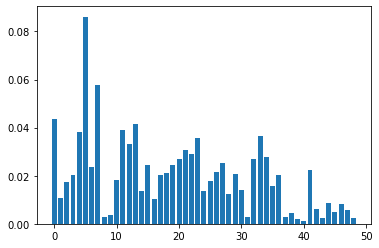

In [38]:
from matplotlib import pyplot

pyplot.bar(range(len(clf_boruta.feature_importances_)), clf_boruta.feature_importances_)
pyplot.show()

In [39]:
counter = 0
for col in selected_boruta_col:
    print(f"{counter}==> {col}")
    counter +=1

0==> credit_hh_nonmtgcredit_60dpd
1==> rx_bh_pmpm_ct_0to3m_b4
2==> rx_overall_gpi_pmpm_ct_0to3m_b4
3==> atlas_vlfoodsec_13_15
4==> credit_hh_bankcard_severederog
5==> est_age
6==> cnt_cp_webstatement_pmpm_ct
7==> rwjf_uninsured_adults_pct
8==> lab_albumin_loinc_pmpm_ct
9==> rev_pm_obsrm_pmpm_ct
10==> atlas_pct_sfsp15
11==> cms_tot_partd_payment_amt
12==> rx_nonbh_mbr_resp_pmpm_cost
13==> rwjf_uninsured_child_pct
14==> atlas_foodinsec_child_03_11
15==> cons_nwperadult
16==> lab_dist_loinc_pmpm_ct
17==> atlas_pct_nslp15
18==> rx_generic_pmpm_ct_0to3m_b4
19==> rx_overall_mbr_resp_pmpm_cost_0to3m_b4
20==> rx_maint_pmpm_ct_9to12m_b4
21==> cms_risk_adjustment_factor_a_amt
22==> rx_generic_pmpm_cost
23==> rx_generic_pmpm_cost_6to9m_b4
24==> rx_tier_1_pmpm_ct_0to3m_b4
25==> cons_estinv30_rc
26==> atlas_pct_sbp15
27==> atlas_pct_cacfp15
28==> pdc_lip
29==> rx_tier_2_pmpm_ct
30==> atlas_foodinsec_13_15
31==> rx_gpi2_56_dist_gpi6_pmpm_ct_3to6m_b4
32==> cons_cgqs
33==> zip_cd
34==> cons_lwcm07
35=

In [53]:
from sklearn.ensemble import GradientBoostingClassifier

clf_boruta_2 = GradientBoostingClassifier(n_estimators=1500, learning_rate=0.01, max_depth=5, random_state=0)
clf_boruta_2.fit(X_filtered, y_strat_train)


roc_auc_score(y_strat_test, clf_boruta_2.predict_proba(X_test_filtered)[:, 1])

0.6802118971250706

# LogisticRegression

In [41]:
from sklearn.linear_model import LogisticRegression

lr_model = LogisticRegression(max_iter=10000)
lr_model.fit(X_filtered, y_strat_train)

roc_auc_score(y_strat_test, lr_model.predict_proba(X_test_filtered)[:, 1])

0.6535516157601756

# XG Boost

In [42]:
from statistics import mean
from statistics import stdev
import time
import numpy as np
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

In [43]:
import xgboost as xgb


model_1 = xgb.XGBClassifier(
 learning_rate =0.05,
 n_estimators=1000,
 max_depth=10,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)

model_1.fit(X_filtered, y_strat_train)
roc_auc_score(y_strat_test, model_1.predict_proba(X_test_filtered)[:, 1])

[23:44:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


0.6720910061245289

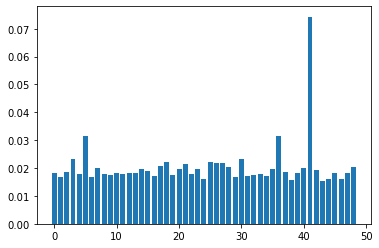

In [44]:
from matplotlib import pyplot

pyplot.bar(range(len(model_1.feature_importances_)), model_1.feature_importances_)
pyplot.show()

In [45]:
counter = 0
for col in selected_boruta_col:
    print(f"{counter}==> {col}")
    counter +=1

0==> credit_hh_nonmtgcredit_60dpd
1==> rx_bh_pmpm_ct_0to3m_b4
2==> rx_overall_gpi_pmpm_ct_0to3m_b4
3==> atlas_vlfoodsec_13_15
4==> credit_hh_bankcard_severederog
5==> est_age
6==> cnt_cp_webstatement_pmpm_ct
7==> rwjf_uninsured_adults_pct
8==> lab_albumin_loinc_pmpm_ct
9==> rev_pm_obsrm_pmpm_ct
10==> atlas_pct_sfsp15
11==> cms_tot_partd_payment_amt
12==> rx_nonbh_mbr_resp_pmpm_cost
13==> rwjf_uninsured_child_pct
14==> atlas_foodinsec_child_03_11
15==> cons_nwperadult
16==> lab_dist_loinc_pmpm_ct
17==> atlas_pct_nslp15
18==> rx_generic_pmpm_ct_0to3m_b4
19==> rx_overall_mbr_resp_pmpm_cost_0to3m_b4
20==> rx_maint_pmpm_ct_9to12m_b4
21==> cms_risk_adjustment_factor_a_amt
22==> rx_generic_pmpm_cost
23==> rx_generic_pmpm_cost_6to9m_b4
24==> rx_tier_1_pmpm_ct_0to3m_b4
25==> cons_estinv30_rc
26==> atlas_pct_sbp15
27==> atlas_pct_cacfp15
28==> pdc_lip
29==> rx_tier_2_pmpm_ct
30==> atlas_foodinsec_13_15
31==> rx_gpi2_56_dist_gpi6_pmpm_ct_3to6m_b4
32==> cons_cgqs
33==> zip_cd
34==> cons_lwcm07
35=

# Shap Analysis

In [46]:
shap.initjs()

In [47]:
explainer = shap.TreeExplainer(clf_boruta)
shap_values = explainer.shap_values(X_filtered)

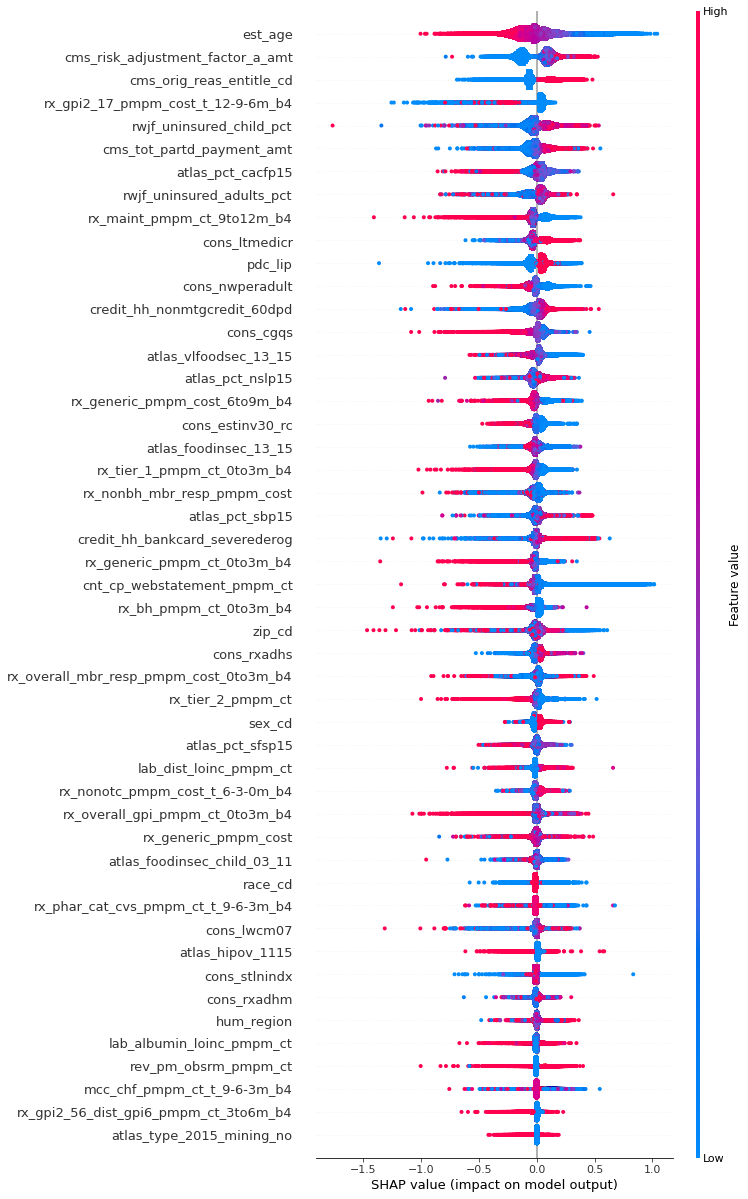

In [48]:
#shap.summary_plot(shap_values, features=X_filtered, feature_names=boruta_col)
shap.summary_plot(shap_values, X_filtered, feature_names = selected_boruta_col, max_display = 50)

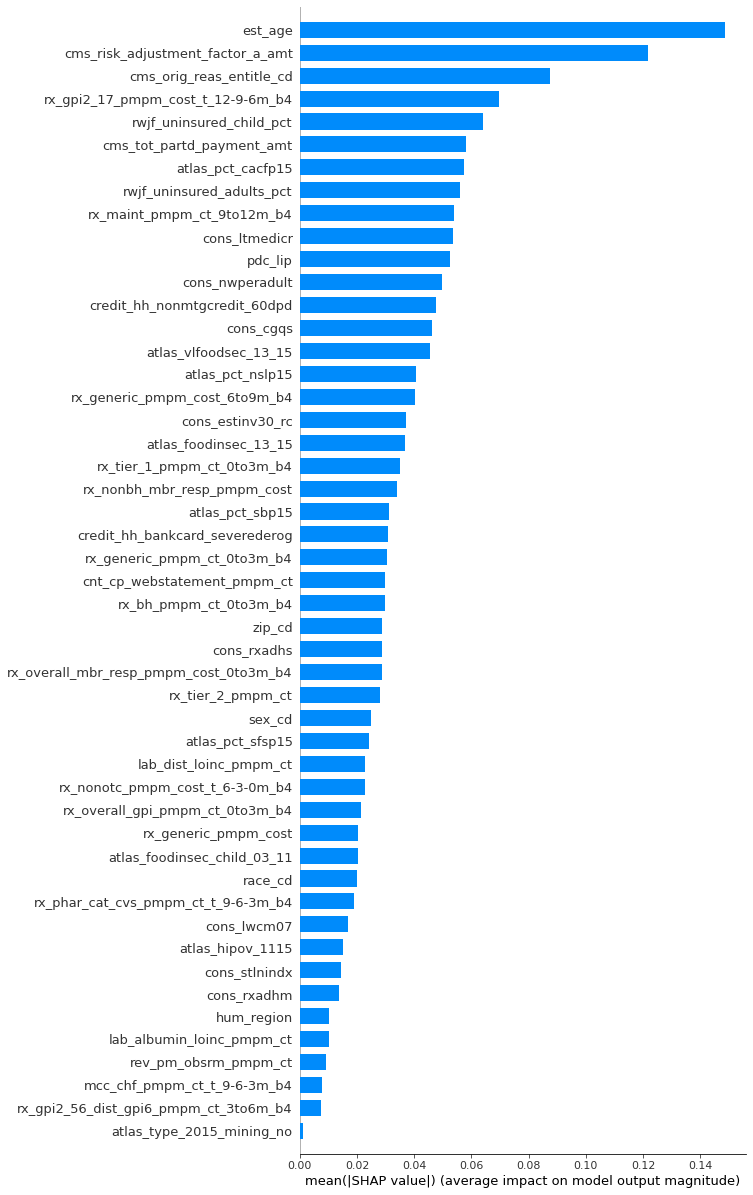

In [49]:
shap.summary_plot(shap_values, X_filtered, plot_type='bar',feature_names = boruta_col, max_display = 50)

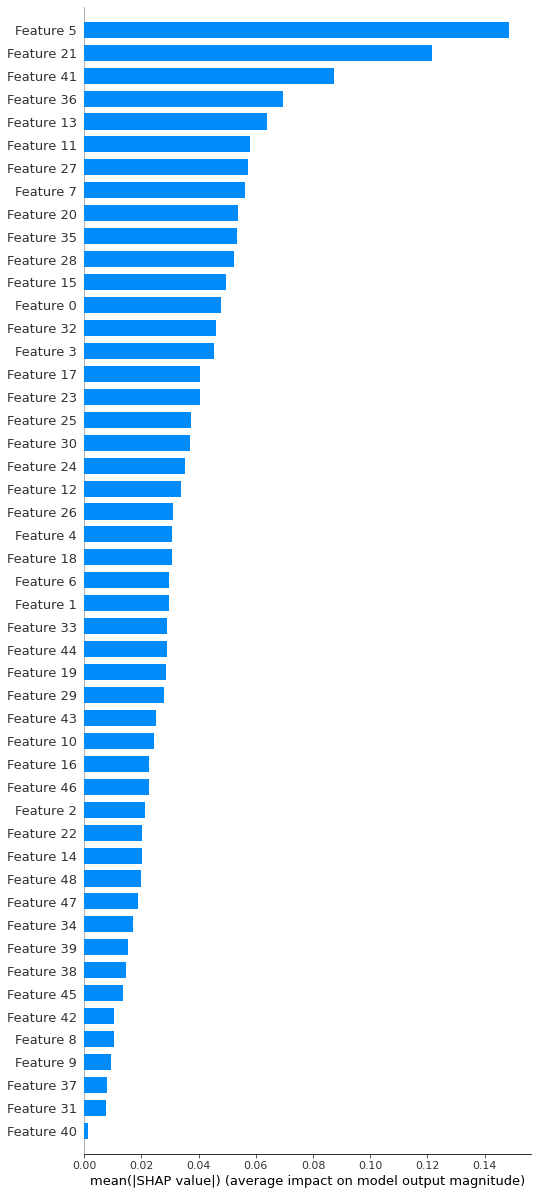

In [50]:
shap.summary_plot(shap_values, X_filtered, plot_type='bar', max_display = 50)

# Scaling and Transforming Holdout File 

In [33]:
holdout_df = pd.read_csv('Clean_holdout_file_ID.csv', low_memory=False)
holdout_df = holdout_df.drop(['Unnamed: 0'], axis = 1)

ParserError: Error tokenizing data. C error: out of memory

In [ ]:
col_list = ['bh_ncdm_ind','bh_ncal_ind','race_cd']


counter = 0
for col in col_list:
    df1[col] = holdout_df[col].astype(str)
    print(f"{counter} {col} --> {holdout_df[col].unique()} --> {holdout_df[col].dtypes}")
    counter += 1 

In [ ]:
holdout_df1 = holdout_df.copy(deep = True)

In [ ]:
counter = 1
for col in holdout_df1.columns:
    if holdout_df1[col].dtypes != 'object' and holdout_df1[col].skew() > 50 :   # Can possibly add .nunique to prevent categorical column transformation
        print(f"{counter}--{col} --> {holdout_df1[col].skew()}")
        holdout_df1.drop(col, inplace=True, axis =1)
        counter += 1

In [ ]:
counter = 1
for col in holdout_df1.columns:
    if holdout_df1[col].dtypes != 'object' and holdout_df1[col].skew() > 10:
        print(f"{counter}--{col} --> {holdout_df1[col].skew()}")
        holdout_df1[col] = np.log(holdout_df1[col]+1)
        print(f"{counter}--{col} --> {holdout_df1[col].skew()}")
        counter += 1

In [ ]:
def race(x):
    if x == '1.0':
        return 'White'
    else:
        return 'Others'

holdout_df1["race_cd"] = np.vectorize(race)(holdout_df1['race_cd'])

In [ ]:
holdout_df1_ID = holdout_df1[['ID']]
holdout_df2 = holdout_df1.drop("ID", axis =1)

In [ ]:
holdout_df2_prepared = full_pipeline.transform(holdout_df2)

In [ ]:
holdout_df2_prepared_filtered = feat_selector.transform(holdout_df2_prepared)

In [ ]:
result = pd.DataFrame(clf_boruta.predict_proba(holdout_df2_prepared_filtered)[:, 1])

In [ ]:
result.head(5)

In [ ]:
final_result = pd.merge(holdout_df1_ID, result, left_index=True, right_index=True)

In [ ]:
final_result['Score'] = final_result[0]

In [ ]:
final_result.drop(columns=0, inplace = True)

In [ ]:
final_result.sort_values(by = 'Score', ascending=False ,inplace = True)

In [ ]:
final_result.reset_index(inplace=True,drop=True)

In [ ]:
final_result['Rank'] = final_result['Score'].rank(method='first', ascending=False)

In [ ]:
final_result.head(5)

final_result.to_csv('2021CaseCompetition_Vasudev_Trived_20211006.csv')